In [1]:
import datetime
from pathlib import Path

import polars as pl
from deltalake import DeltaTable
from tpot import TPOTClassifier, TPOTRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split

c:\Users\achoudh1\ASML\research_external\MLScaling\code\synthetic-data-generator\.venv\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
def train_entity(
        input_data_path, 
        entity_index,
        m_type="classification", 
        sample_fraction=1.0):
    
    entity_partition = f"entity_{entity_index}"
    entity_pldf = pl.read_delta(input_data_path, pyarrow_options={"partitions": [("entity", "=", entity_partition)]})
    entity_pdf = entity_pldf.sample(fraction=sample_fraction).to_pandas()

    features = [s for s in entity_pdf.columns.to_list() if s.isdigit()]
    target = "target"

    # prepare data
    X_train, X_test, y_train, y_test = train_test_split(
        entity_pdf[features], entity_pdf[target], test_size=0.25, random_state=42
    )
    if m_type == "regression":
        model = DecisionTreeRegressor(max_depth=2, random_state=42)
        # model = TPOTRegressor(generations=2, population_size=3, verbosity=2, random_state=42)
    elif m_type == "classification":
        model = DecisionTreeClassifier(max_depth=2, random_state=42)
        # model = TPOTClassifier(generations=2, population_size=3, verbosity=2, random_state=42)

    model.fit(X_train, y_train)
    entity_score = model.score(X_test, y_test)

    return entity_partition, entity_pldf.shape, entity_pdf.shape, entity_score, sample_fraction

In [3]:
m_type = "classification"
input_data_path = f"../data/{m_type}"
dt = DeltaTable(input_data_path)
entity_partitions = dt.partitions()
sample_fraction = 1.0
entity_col = 'entity'

<Axes: ylabel='Density'>

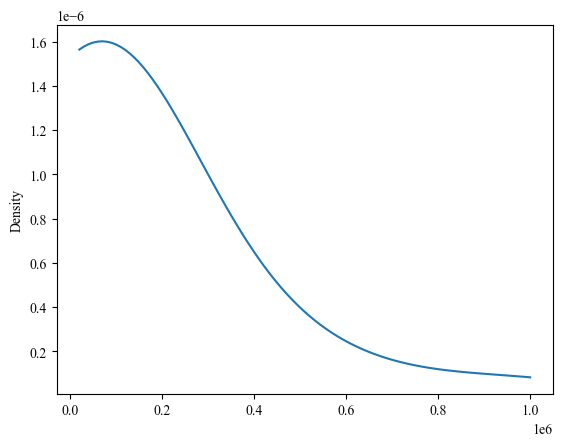

In [10]:
import pandas as pd
from configparser import ConfigParser
config = ConfigParser()
config.read("./../conf/config.ini")
entities = config.sections()
n_items = [(item, int(config.items(item)[0][1])) for item in entities]
distdf = pd.DataFrame(n_items, columns=["entity", "n_items"])
distdf["n_items"].plot.kde(bw_method=1, ind=list(range(1_000_000, 1_000_0, -1_000_0)))

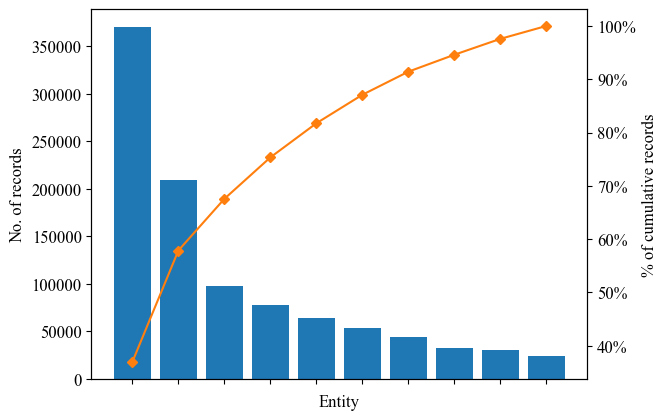

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

distdf = distdf.sample(10)
distdf = distdf.sort_values(by="n_items",ascending=False)
distdf["cumpercentage"] = distdf["n_items"].cumsum()/distdf["n_items"].sum()*100


fig, ax = plt.subplots()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
ax.bar(distdf["entity"], distdf["n_items"], color="C0")
ax2 = ax.twinx()
ax2.plot(distdf["entity"], distdf["cumpercentage"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y") # , colors="C0"
ax2.tick_params(axis="y") # , colors="C1"
ax.set_xticklabels([])
ax.set_xlabel("Entity", fontsize=12, fontfamily="Times New Roman")
ax.set_ylabel("No. of records", fontsize=12, fontfamily="Times New Roman")
ax2.set_ylabel("% of cumulative records", fontsize=12, fontfamily="Times New Roman")
plt.show()

In [40]:
list(range(0, len(entities)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [4]:
output = []
start_time_ray =  datetime.datetime.now()

for part in entity_partitions:
    entity_index = part[entity_col].split("_")[-1]
    output.append(train_entity(
        input_data_path, entity_index, m_type=m_type, sample_fraction=sample_fraction))

In [5]:
output

[('entity_18', (695949, 22), (695949, 22), 0.8689679748028599, 1.0),
 ('entity_15', (52956, 22), (52956, 22), 0.9068660774983005, 1.0),
 ('entity_3', (98609, 22), (98609, 22), 0.9342879162779377, 1.0),
 ('entity_19', (527341, 22), (527341, 22), 0.9180952091993082, 1.0),
 ('entity_6', (85462, 22), (85462, 22), 0.9061593185434803, 1.0),
 ('entity_7', (96429, 22), (96429, 22), 0.9602206736353078, 1.0),
 ('entity_4', (85679, 22), (85679, 22), 0.9330999066293184, 1.0),
 ('entity_12', (21298, 22), (21298, 22), 0.8828169014084507, 1.0),
 ('entity_11', (47285, 22), (47285, 22), 0.936728133987481, 1.0),
 ('entity_14', (21515, 22), (21515, 22), 0.8689347462353597, 1.0),
 ('entity_16', (474961, 22), (474961, 22), 0.8937856342796506, 1.0),
 ('entity_10', (17139, 22), (17139, 22), 0.9495915985997666, 1.0),
 ('entity_17', (746087, 22), (746087, 22), 0.8913532988065751, 1.0),
 ('entity_9', (30487, 22), (30487, 22), 0.9002886381527159, 1.0),
 ('entity_8', (62890, 22), (62890, 22), 0.8927685556191567, 

: 